<a href="https://colab.research.google.com/github/bugremover/-Twitter-Clone-API-Documentation/blob/main/bhargav_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and predict their gender based on face images. Please read carefully all the instructions before you start to write your code.

**Your Tasks**

You are supposed to train two CNN models.
- Model A: Train a CNN model from scratch, following a few restrictions. Save this model as `age_gender_A.keras`
- Model B: Fine-tune a pre-trained model to perform the same task. Save this model as `age_gender_B.keras`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During the assessment phase, your code will be tested on unseen test data.

**Performance Metric**

The evaluation of your models on the test set will be based on the following metrics:
- age estimation: - Mean Absolute Error (MAE)
- gender prediction: accuracy

**GPU Time Management**

Please use the available GPU time wisely, as there are some limitations on free GPU usage. It is said the users can use up to 12 hours in row in Google Colab. But many people found they reached its limit far less than 12 hours. To minimize the risk of reaching the limit, consider the following suggestions:
1. Ensure you have a stable internet connection.
2. Carefully validate your hyperparameters before starting the training process.
3. Based on past experience, each model should be trained in less than 2 hours. If the training time is significantly longer, you may need to adjust your model architecture.


## Setting Up: Mount the google drive
Mount your google drive to the notebook. Also don't forget to **enable GPU** before your training.


In [ ]:

# Optional: Mount Google Drive if running in Colab, otherwise default to local paths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
data_dir = '/content/drive/MyDrive/datasets/train_val'
print('Files in dataset :',len(os.listdir(data_dir)))

Files in dataset : 5000


## Visualize a few photos
It's always beneficial to thoroughly understand your data before beginning the training process. To get a first-hand impression of the dataset, please display a minimum of 20 images from the `train_val/` folder, along with their corresponding age and gender labels. This will help you gain initial insights into the dataset.

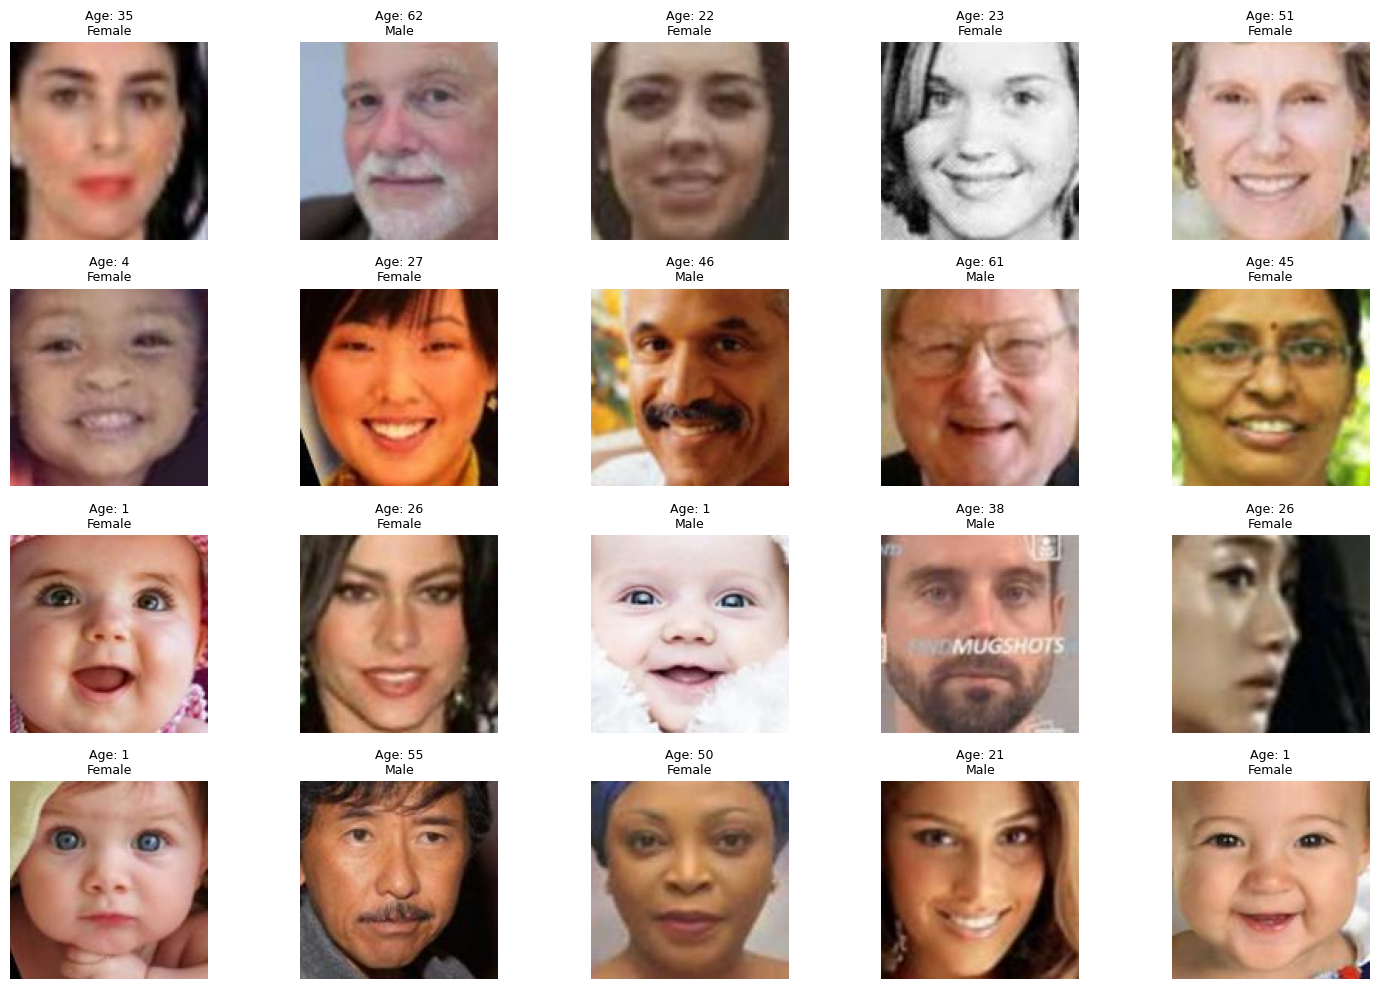

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from matplotlib.image import imread

# Define the path to the dataset
dataset_path = '/content/drive/MyDrive/datasets/train_val'

# Get the list of image filenames in the dataset folder
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# Randomly select 20 images
sample_images = random.sample(image_files, 20)

# Set up the plot grid (4 rows, 5 columns)
plt.figure(figsize=(15, 10))

# Loop over the selected images
for i, img_filename in enumerate(sample_images):
    # Create the full image path
    img_path = os.path.join(dataset_path, img_filename)

    # Read the image using imread
    img = imread(img_path)

    # Extract age and gender from the filename
    parts = img_filename.split('_')
    age = int(parts[0])  # Age is the first part
    gender_value = int(parts[1])  # Gender is the second part (0 = Male, 1 = Female)
    gender = 'Male' if gender_value == 0 else 'Female'

    # Create a subplot for each image (4 rows, 5 columns)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis

    # Set the title for the subplot with age and gender
    plt.title(f"Age: {age}\n{gender}", fontsize=9)

# Adjust layout for better spacing
plt.tight_layout()

# Show the images
plt.show()


## Step 1: Data Pre-Processing
In this step, you will perform necessary pre-processing tasks before feeding the data into a CNN. The pre-processing includes:

1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation

The first two pre-processing steps have already been completed for you. Your task in this step is limited to:

3. Data augmentation

Please note:

- Do not modify any part of the provided code except the section marked with ########.
- Do not rescale the age values to the range [0,1], as the original values are used during the testing stage. Rescaling them would significantly impact testing performance.



In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import Sequential, layers


folder_train_val = '/content/drive/MyDrive/datasets/train_val'
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name))
    img = img / 255.0  # Normalize pixel values
    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

#
######### Add your code for data augmentation here #########
import tensorflow as tf
from tensorflow.keras import layers, Sequential

print("Creating TensorFlow data pipelines...")

BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE


# 1) Augmentation block (for faces)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),          # left-right flip
    layers.RandomRotation(0.08),              # ~±8°; more can distort faces
    layers.RandomZoom(height_factor=(-0.1, 0.1),
                      width_factor=(-0.1, 0.1)),  # slight zoom in/out
    layers.RandomTranslation(0.05, 0.05),     # shift up to 5% of width/height
    layers.RandomContrast(0.1),               # small lighting variation
], name="data_augmentation")


# 2) Preprocess helpers

def normalize(image, labels):
    # assumes image is uint8 [0,255]
    image = tf.image.convert_image_dtype(image, tf.float32)  # -> [0,1]
    return image, labels

def augment(image, labels):
    image = data_augmentation(image, training=True)
    return image, labels

# 3) Base datasets from numpy
train_base = tf.data.Dataset.from_tensor_slices(
    (train_images, (train_age, train_gender))
)
val_base = tf.data.Dataset.from_tensor_slices(
    (val_images, (val_age, val_gender))
)


# 4) Train pipeline

train_ds = (
    train_base
    .shuffle(buffer_size=len(train_images), reshuffle_each_iteration=True)
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .map(augment,   num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


# 5) Val pipeline (NO augmentation)

val_ds = (
    val_base
    .map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()          # same val images every epoch, faster & stable
    .prefetch(AUTOTUNE)
)

print("tf.data pipelines with enhanced augmentation are ready for training.")


Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...
Creating TensorFlow data pipelines...
tf.data pipelines with enhanced augmentation are ready for training.


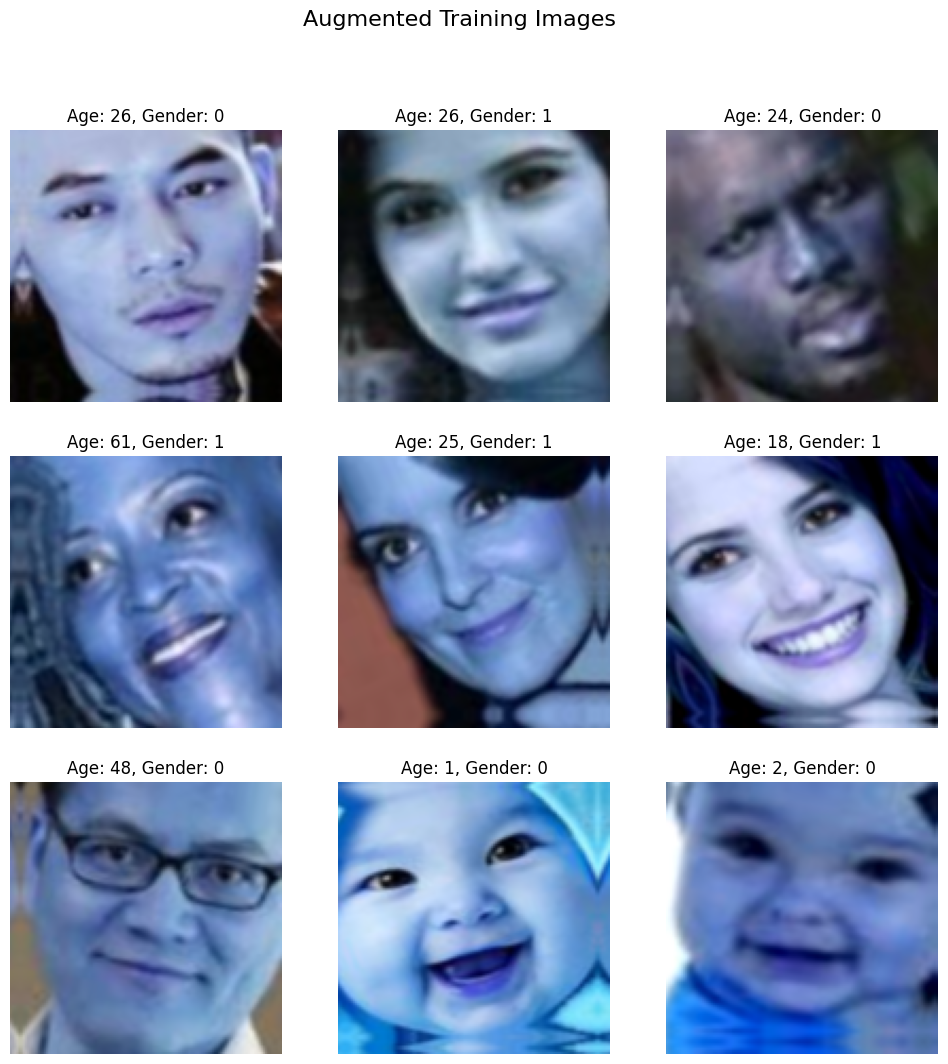

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    age_labels, gender_labels = labels
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Age: {age_labels[i].numpy():.0f}, Gender: {gender_labels[i].numpy():.0f}")
        plt.axis("off")
    plt.suptitle("Augmented Training Images", fontsize=16)
    plt.show()

## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

Model: "ModelA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      9,248 │ re_lu_29[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ re_lu_30[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_31[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ re_lu_32[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_33[0][0] 

 Total params: 6,432,610 (24.54 MB)

 Trainable params: 6,425,570 (24.51 MB)

 Non-trainable params: 7,040 (27.50 KB)

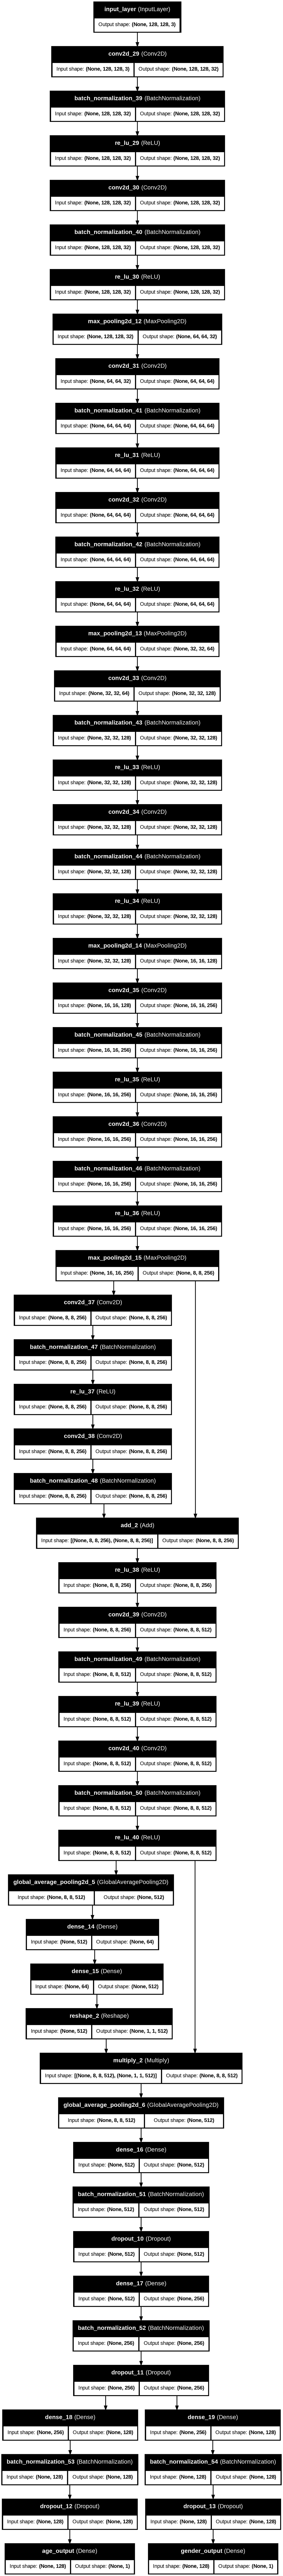

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model

input_shape = (128, 128, 3)
inputs = tf.keras.Input(shape=input_shape, name="input_layer")

weight_decay = 1e-4

# ---------- Feature extractor ----------

# Block 1: 32 filters (2x conv) + MaxPool
x = layers.Conv2D(
    32, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(
    32, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D((2, 2))(x)   # 128 -> 64

# Block 2: 64 filters (2x conv) + MaxPool
x = layers.Conv2D(
    64, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(
    64, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D((2, 2))(x)   # 64 -> 32

# Block 3: 128 filters (2x conv) + MaxPool
x = layers.Conv2D(
    128, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(
    128, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D((2, 2))(x)   # 32 -> 16

# Block 4: 256 filters (2x conv) + MaxPool + Residual block
x = layers.Conv2D(
    256, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(
    256, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D((2, 2))(x)   # 16 -> 8

shortcut = x

res = layers.Conv2D(
    256, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
res = layers.BatchNormalization()(res)
res = layers.ReLU()(res)

res = layers.Conv2D(
    256, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(res)
res = layers.BatchNormalization()(res)

x = layers.Add()([shortcut, res])
x = layers.ReLU()(x)

# Block 5: 512 filters (2x conv), NO pooling (keep spatial info 8x8)
x = layers.Conv2D(
    512, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(
    512, (3, 3),
    padding='same',
    activation=None,
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)



se = layers.GlobalAveragePooling2D()(x)
se = layers.Dense(512 // 8, activation='relu')(se)
se = layers.Dense(512, activation='sigmoid')(se)
se = layers.Reshape((1, 1, 512))(se)

x = layers.Multiply()([x, se])

# Global pooling to vector
x = layers.GlobalAveragePooling2D()(x)

# ---------- Shared Dense representation ----------

x = layers.Dense(
    512,
    activation='relu',
    kernel_regularizer=regularizers.l2(weight_decay)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# ---------- Task-specific heads ----------

# Age head (regression)
age_branch = layers.Dense(128, activation='relu')(x)
age_branch = layers.BatchNormalization()(age_branch)
age_branch = layers.Dropout(0.2)(age_branch)
age_output = layers.Dense(1, name='age_output')(age_branch)

# Gender head (binary classification)
gender_branch = layers.Dense(128, activation='relu')(x)
gender_branch = layers.BatchNormalization()(gender_branch)
gender_branch = layers.Dropout(0.2)(gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# ---------- Model ----------

modelA = models.Model(
    inputs=inputs,
    outputs=[age_output, gender_output],
    name='ModelA'
)

modelA.summary()
plot_model(modelA, to_file='modelA.png', show_shapes=True, show_layer_names=True)


## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.keras")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()`** to save the entire model (including a model's architecture, weights, and training configuration) as a `.keras` zip archive. Don't save it with `save_weights()`.


In [ ]:
# ✅ STEP 3A: Compile and Train Model A
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Compile the model ---
modelA.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'age_output': 'mae',
        'gender_output': 'binary_crossentropy'
    },
    loss_weights={
        'age_output': 0.8,   # reduce regression influence
        'gender_output': 1.0
    },
    metrics={
        'age_output': ['mae'],
        'gender_output': ['accuracy']
    }
)

# --- Define callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

# --- Train the model ---
EPOCHS = 100
history = modelA.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# --- Save the model (do NOT change this filename) ---
your_model_folder = '/content/drive/MyDrive/datasets/'
modelA.save(your_model_folder + "age_gender_A.keras")

print("Model saved successfully at:", your_model_folder + "age_gender_A.keras")


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - age_output_loss: 32.8231 - age_output_mae: 32.8231 - gender_output_accuracy: 0.5861 - gender_output_loss: 0.7857 - loss: 27.3100 - val_age_output_loss: 33.1253 - val_age_output_mae: 33.0397 - val_gender_output_accuracy: 0.4870 - val_gender_output_loss: 0.7163 - val_loss: 27.4161 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - age_output_loss: 32.7905 - age_output_mae: 32.7905 - gender_output_accuracy: 0.6088 - gender_output_loss: 0.7204 - loss: 27.2183 - val_age_output_loss: 34.2696 - val_age_output_mae: 34.1842 - val_gender_output_accuracy: 0.4870 - val_gender_output_loss: 0.9512 - val_loss: 28.5726 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - age_output_loss: 31.8095 - age_output_mae: 31.8095 - gender_output_accuracy: 0.6502 - gender_output_loss: 0.6866 - loss: 26.3997 - val_age_output_loss: 33.9756 - val_age_output_mae: 33.8859 - val_gender_output

## STEP4A: Draw the learning curves
Draw four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

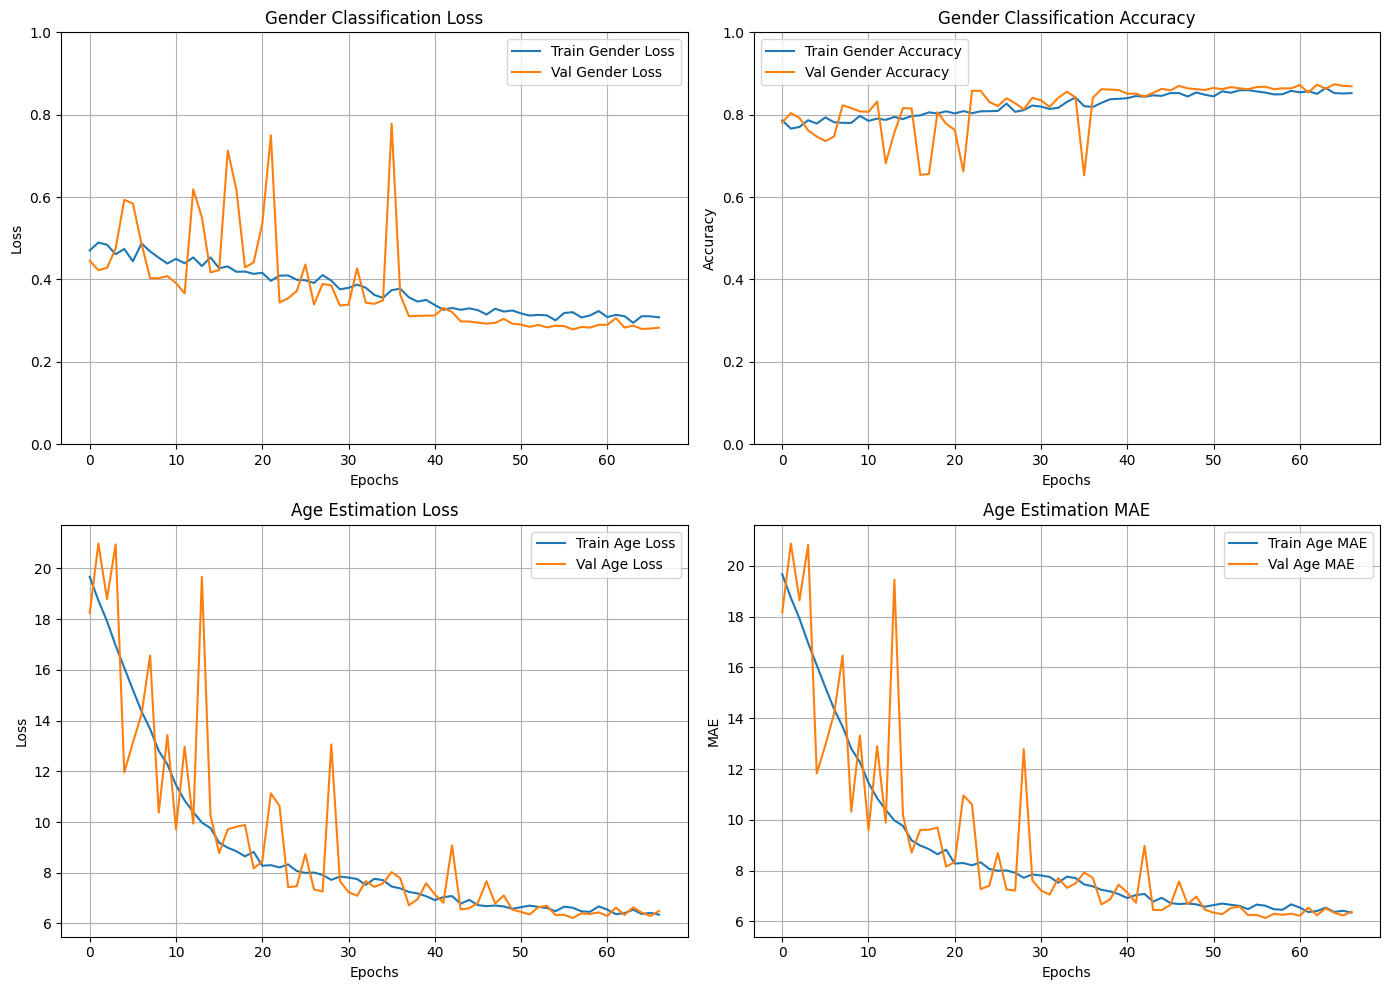

In [ ]:
# STEP 4A: Draw the learning curves
import matplotlib.pyplot as plt

# Retrieve the training history
hist = history.history

plt.figure(figsize=(14, 10))

#  Gender classification loss
plt.subplot(2, 2, 1)
plt.plot(hist['gender_output_loss'], label='Train Gender Loss')
plt.plot(hist['val_gender_output_loss'], label='Val Gender Loss')
plt.title('Gender Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

#  Gender classification accuracy
plt.subplot(2, 2, 2)
plt.plot(hist['gender_output_accuracy'], label='Train Gender Accuracy')
plt.plot(hist['val_gender_output_accuracy'], label='Val Gender Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.grid(True)

#  Age estimation loss
plt.subplot(2, 2, 3)
plt.plot(hist['age_output_loss'], label='Train Age Loss')
plt.plot(hist['val_age_output_loss'], label='Val Age Loss')
plt.title('Age Estimation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#  Age estimation MAE
plt.subplot(2, 2, 4)
plt.plot(hist['age_output_mae'], label='Train Age MAE')
plt.plot(hist['val_age_output_mae'], label='Val Age MAE')
plt.title('Age Estimation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
